In [31]:
# Data Processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [32]:
# Load dataset
file_path = "Coffe_sales.csv"
df = pd.read_csv(file_path)

# Tampilkan 5 data awal
df.head()


,date,datetime,hour_of_day,cash_type,card,money,coffee_name,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort
0,01/03/2024,01/03/2024 10:15:50,10,card,ANON-0000-0000-0001,R38.70,Latte,Morning,Fri,Mar,5,3
1,01/03/2024,01/03/2024 12:19:22,12,card,ANON-0000-0000-0002,R38.70,Hot Chocolate,Afternoon,Fri,Mar,5,3
2,01/03/2024,01/03/2024 12:20:18,12,card,ANON-0000-0000-0002,R38.70,Hot Chocolate,Afternoon,Fri,Mar,5,3
3,01/03/2024,01/03/2024 13:46:33,13,card,ANON-0000-0000-0003,R28.90,Americano,Afternoon,Fri,Mar,5,3
4,01/03/2024,01/03/2024 13:48:14,13,card,ANON-0000-0000-0004,R38.70,Latte,Afternoon,Fri,Mar,5,3


In [33]:
# 1. Remove duplicates first
df = df.drop_duplicates()

# 2. Remove the 'R' symbol and convert to float
# This replaces 'R' with nothing, effectively removing it
df["money"] = df["money"].astype(str).str.replace('R', '')

# 3. NOW convert to numeric (it will work now because 'R' is gone)
df["money"] = pd.to_numeric(df["money"])

# 4. Filter missing values or negative numbers
df = df.dropna(subset=["money"])
df = df[df["money"] >= 0]

# Check the results
print("Jumlah baris df :", df.shape)
print(df["money"].describe())


Jumlah baris df : (3636, 12)
count    3636.000000
mean       31.746859
std         4.919926
min        18.120000
25%        27.920000
50%        32.820000
75%        35.760000
max        40.000000
Name: money, dtype: float64


In [34]:
# Konversi tanggal
df["date"] = pd.to_datetime(df["date"], dayfirst=True)


# Hitung revenue (1 transaksi = 1 baris)
df["revenue"] = df["money"]

# Ekstraksi fitur waktu
df["month"] = df["date"].dt.month
df["day_of_week"] = df["date"].dt.dayofweek  # 0=Senin, 6=Minggu

df.head()


,date,datetime,hour_of_day,cash_type,card,money,coffee_name,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort,revenue,month,day_of_week
0,2024-03-01,01/03/2024 10:15:50,10,card,ANON-0000-0000-0001,38.7,Latte,Morning,Fri,Mar,5,3,38.7,3,4
1,2024-03-01,01/03/2024 12:19:22,12,card,ANON-0000-0000-0002,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,38.7,3,4
2,2024-03-01,01/03/2024 12:20:18,12,card,ANON-0000-0000-0002,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,38.7,3,4
3,2024-03-01,01/03/2024 13:46:33,13,card,ANON-0000-0000-0003,28.9,Americano,Afternoon,Fri,Mar,5,3,28.9,3,4
4,2024-03-01,01/03/2024 13:48:14,13,card,ANON-0000-0000-0004,38.7,Latte,Afternoon,Fri,Mar,5,3,38.7,3,4


In [35]:
X = df[[
    "coffee_name",
    "hour_of_day",
    "month",
    "day_of_week"
]]

y = df["revenue"]



In [36]:
# Fitur numerik & kategorikal
numeric_features = [
    "hour_of_day",
    "month",
    "day_of_week"
]

categorical_features = [
    "coffee_name"
]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [38]:
numeric_features = ["hour_of_day", "month", "day_of_week"]
categorical_features = ["coffee_name"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

df.to_csv('hasil.csv', index=False)


In [39]:
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=100,
        random_state=42
    ))
])


In [40]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE :", rmse)
print("R² Score :", r2)


RMSE : 0.7950724275405813
R² Score : 0.9742335500080366


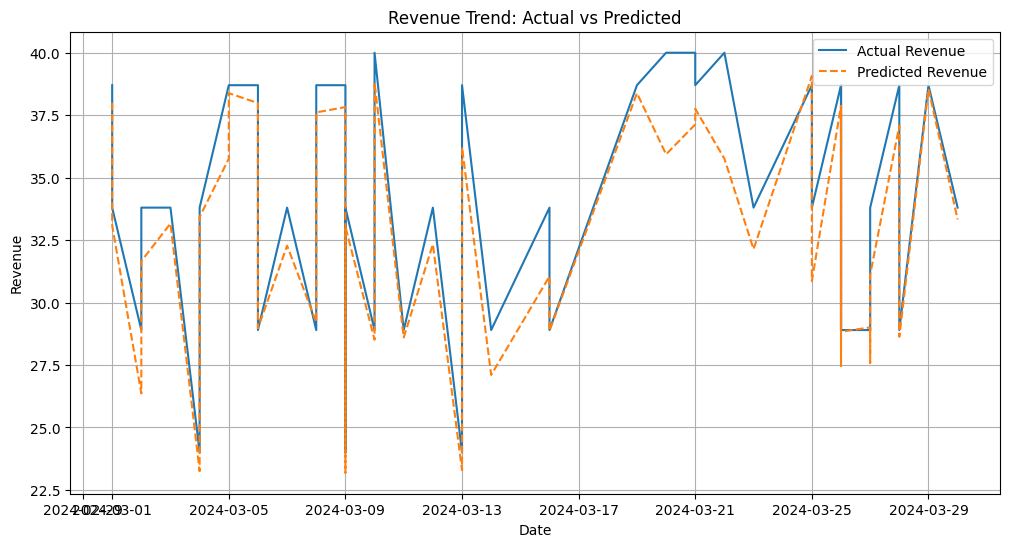

In [57]:
# 1. Pastikan kolom date sudah dalam format datetime agar filter berfungsi
X_test_plot = df.loc[X_test.index, ["date"]].copy()
X_test_plot["Actual"] = y_test.values
X_test_plot["Predicted"] = y_pred
X_test_plot["date"] = pd.to_datetime(X_test_plot["date"])

# 2. Tentukan rentang waktu
start_date = "2024-03-01"
end_date = "2024-03-31"

# 3. Filter langsung dari X_test_plot yang sudah punya Actual & Predicted
df_monthly = X_test_plot[(X_test_plot["date"] >= start_date) & (X_test_plot["date"] <= end_date)]

# 4. Urutkan berdasarkan tanggal agar garis di chart tidak berantakan
df_monthly = df_monthly.sort_values("date")

plt.figure(figsize=(12,6))

plt.plot(df_monthly["date"], df_monthly["Actual"], label="Actual Revenue")
plt.plot(df_monthly["date"], df_monthly["Predicted"], linestyle="--", label="Predicted Revenue")

plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Revenue Trend: Actual vs Predicted")
plt.legend()
plt.grid(True)

plt.show()



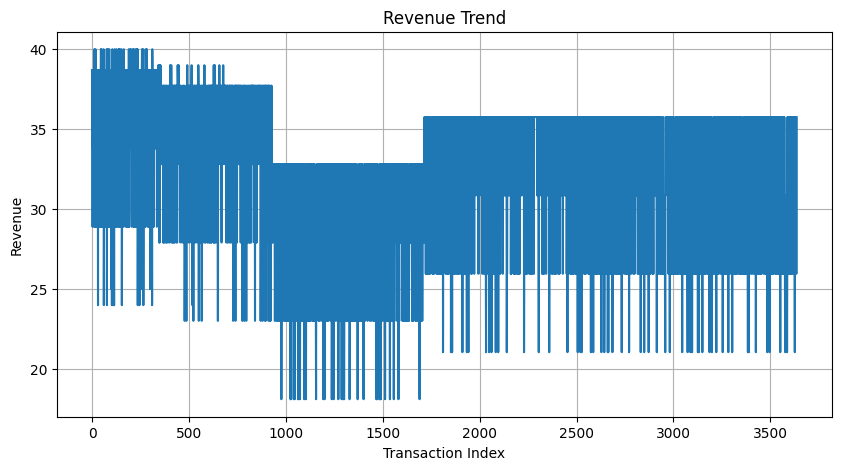

In [42]:
plt.figure(figsize=(10,5))

plt.plot(df["revenue"].values)
plt.xlabel("Transaction Index")
plt.ylabel("Revenue")
plt.title("Revenue Trend")

plt.grid(True)
plt.show()



In [48]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, month, dayofweek

spark = SparkSession.builder \
    .appName("CoffeeShopRevenue") \
    .getOrCreate()

# Load data
spark_df = spark.read.csv(
    "hasil.csv",
    header=True,
    inferSchema=True
)

# Cleaning
spark_df = spark_df.dropna().dropDuplicates()

# Konversi date ke date type
spark_df = spark_df.withColumn(
    "date",
    col("date").cast("date")
)

# Revenue (1 transaksi = 1 baris)
spark_df = spark_df.withColumn(
    "revenue",
    col("money")
)

# Ekstraksi waktu
spark_df = spark_df.withColumn(
    "month",
    month("date")
)

spark_df = spark_df.withColumn(
    "day_of_week",
    dayofweek("date")
)
daily_revenue = spark_df.groupBy("date") \
    .sum("revenue") \
    .withColumnRenamed("sum(revenue)", "daily_revenue")

daily_revenue.show(10)



+----------+------------------+
|      date|     daily_revenue|
+----------+------------------+
|2024-09-18|            121.48|
|2025-02-16|             313.5|
|2024-05-30|370.81999999999994|
|2024-06-12|            221.42|
|2024-06-04|            474.18|
|2024-08-27|             32.82|
|2024-10-24|497.19999999999993|
|2024-11-25|            373.76|
|2024-05-25|196.91999999999996|
|2025-02-01|            349.26|
+----------+------------------+
only showing top 10 rows
